In [ ]:
#Uso de librerías. Celda nº1
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import warnings
from collections import defaultdict
from tabulate import tabulate
from google.colab import data_table
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Cargar el archivo Excel
xls = pd.ExcelFile("Test_animales.xlsx")
# Leer las hojas y asignar la nueva variable "degenera"
df_list = []
for i, sheet in enumerate(xls.sheet_names):
    df = xls.parse(sheet)
    df["degenera"] = i  # Asigna 0 a la primera hoja, 1 a la segunda, etc.
    df_list.append(df)

# Unir todas las hojas en un solo DataFrame
df = pd.concat(df_list, ignore_index=True)
# Guardar el resultado en un CSV
df.to_csv("Test_animales.csv", index=False)


data = pd.read_csv("Test_animales.csv", header =2)
# Asignar la primera fila como nombres de columnas
data.columns = data.iloc[0]  # Toma la primera fila como encabezados
data = data[1:].reset_index(drop=True)  # Eliminar la fila duplicada y resetear índice

# Asegurar que no hay nombres de columna repetidos
data.columns = [str(col) for col in data.columns]
display(data)

,Edad sacrificio,ID animal,Sexo,P30,3m,4m,6m,9m,12m,17-21m,...,OI,OD,OI,F.Optomotor,Edad Opto,Dato OPT,F.OCT,OD (400 um),OI,0
0,1,WT-25,♀,110220-5,NaN,NaN,NaN,NaN,NaN,NaN,...,19.5,146.7,166.1,2020-02-17 00:00:00,"1,3m",0.572,2020-02-17 00:00:00,52.818,202.818,0
1,1,WT-110,♀,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,1,WT-111,♂,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,1,WT-112,♀,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1,WT-113,♂,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,P11,R10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
255,P11,R11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
256,P11,R12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
257,P11,R13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [ ]:
# Contador para cada nombre de columna duplicada
oi_counter = 1
od_counter = 1
new_columns = []

# Renombrar correctamente las columnas duplicadas de OI y OD
for col in data.columns:
    if col.startswith("OI"):
        new_columns.append(f"OI_{oi_counter}")
        oi_counter += 1
    elif col.startswith("OD"):
        new_columns.append(f"OD_{od_counter}")
        od_counter += 1
    elif col.startswith("0"):
        new_columns.append("degenera")
    else:
        new_columns.append(col) # Mantener los demás nombres iguales
# Aplicar los nuevos nombres
data.columns = new_columns
# Mostrar el resultado
print(data.columns)


Index(['Edad sacrificio', 'ID animal', 'Sexo', 'P30', '3m', '4m', '6m', '9m',
       '12m', '17-21m', 'OD_1', 'OI_1', 'OD_2', 'OI_2', 'OD_3', 'OI_3', 'OD_4',
       'OI_4', 'F.Optomotor', 'Edad Opto', 'Dato OPT', 'F.OCT', 'OD_5', 'OI_5',
       'degenera'],
      dtype='object')


In [ ]:
# Contar las instancias de cada valor en "degenera"
conteo = data["degenera"].value_counts()
print(conteo)

degenera
0    131
1    128
Name: count, dtype: int64


In [ ]:
# Contar valores NaN en cada columna
nan_counts = data.isna().sum()
print(tabulate(nan_counts.reset_index(), headers=["Variable", "Cantidad de NaN"], tablefmt="pretty"))

+----+-----------------+-----------------+
|    |    Variable     | Cantidad de NaN |
+----+-----------------+-----------------+
| 0  | Edad sacrificio |        4        |
| 1  |    ID animal    |        1        |
| 2  |      Sexo       |       15        |
| 3  |       P30       |       246       |
| 4  |       3m        |       236       |
| 5  |       4m        |       252       |
| 6  |       6m        |       243       |
| 7  |       9m        |       243       |
| 8  |       12m       |       239       |
| 9  |     17-21m      |       241       |
| 10 |      OD_1       |       180       |
| 11 |      OI_1       |       184       |
| 12 |      OD_2       |       181       |
| 13 |      OI_2       |       184       |
| 14 |      OD_3       |       180       |
| 15 |      OI_3       |       184       |
| 16 |      OD_4       |       181       |
| 17 |      OI_4       |       184       |
| 18 |   F.Optomotor   |       160       |
| 19 |    Edad Opto    |       154       |
| 20 |    D

In [ ]:
# Seleccionar columnas que empiezan con "OI", "OD" o "Dato OPT"
oi_od_columns = [col for col in data.columns if col.startswith("OI") or col.startswith("OD") or col.startswith("Dato OPT")]
# Eliminar filas donde TODAS esas columnas sean NaN (si al menos una tiene valor, la fila se queda)
data = data.dropna(subset=oi_od_columns, how="all").reset_index(drop=True)
data.to_csv("Test_animales.csv", index=False)
display(data)

,Edad sacrificio,ID animal,Sexo,P30,3m,4m,6m,9m,12m,17-21m,...,OI_3,OD_4,OI_4,F.Optomotor,Edad Opto,Dato OPT,F.OCT,OD_5,OI_5,degenera
0,1,WT-25,♀,110220-5,NaN,NaN,NaN,NaN,NaN,NaN,...,19.5,146.7,166.1,2020-02-17 00:00:00,"1,3m",0.572,2020-02-17 00:00:00,52.818,202.818,0
1,1.3,WT-23,♀,110220-3,NaN,NaN,NaN,NaN,NaN,NaN,...,19.9,123.1,135.2,2020-02-17 00:00:00,"1,3m",0.574,2020-02-17 00:00:00,47.365,202.364,0
2,1.3,WT-24,♀,110220-4,NaN,NaN,NaN,NaN,NaN,NaN,...,19.3,184.3,183.7,2020-02-17 00:00:00,"1,3m",0.594,2020-02-17 00:00:00,54.94,209.455,0
3,1.3,WT-26,♂,110220-1,NaN,NaN,NaN,NaN,NaN,NaN,...,18.0,131.8,166.9,2020-02-17 00:00:00,"1,3m",0.550,2020-02-17 00:00:00,57.273,212.909,0
4,1.3,WT-27,♂,110220-2,NaN,NaN,NaN,NaN,NaN,NaN,...,16.5,181.2,142.6,2020-02-17 00:00:00,"1,3m",0.616,2020-02-17 00:00:00,51.091,202.545,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,19,12120,♀,NaN,NaN,NaN,NaN,NaN,NaN,110521-5,...,3,52,"84,8",NaN,NaN,"0,308",2021-04-28 00:00:00,NaN,NaN,1
103,20,12004,♀,NaN,NaN,NaN,NaN,NaN,NaN,190521-2,...,"3,2","63,1","57,1",NaN,NaN,"0,297",2021-04-26 00:00:00,NaN,NaN,1
104,20,12045,♂,NaN,NaN,NaN,NaN,NaN,NaN,190521-7,...,4,"93,2",85,NaN,NaN,"0,319",2021-04-27 00:00:00,NaN,NaN,1
105,20,12046,♂,NaN,NaN,NaN,NaN,NaN,NaN,190521-6,...,7,"52,5","91,7",NaN,NaN,"0,308",2021-04-27 00:00:00,NaN,NaN,1


In [ ]:
data.drop('Edad sacrificio',axis =1, inplace =True)
data.drop('F.Optomotor',axis =1, inplace =True)
data.drop('F.OCT',axis =1, inplace =True)
data.drop('ID animal',axis =1, inplace =True)
display(data)

,Sexo,P30,3m,4m,6m,9m,12m,17-21m,OD_1,OI_1,...,OI_2,OD_3,OI_3,OD_4,OI_4,Edad Opto,Dato OPT,OD_5,OI_5,degenera
0,♀,110220-5,NaN,NaN,NaN,NaN,NaN,NaN,224.1,262.1,...,628.0,16.8,19.5,146.7,166.1,"1,3m",0.572,52.818,202.818,0
1,♀,110220-3,NaN,NaN,NaN,NaN,NaN,NaN,147.6,217.6,...,501.6,21.6,19.9,123.1,135.2,"1,3m",0.574,47.365,202.364,0
2,♀,110220-4,NaN,NaN,NaN,NaN,NaN,NaN,318.8,291.6,...,630.5,14.2,19.3,184.3,183.7,"1,3m",0.594,54.94,209.455,0
3,♂,110220-1,NaN,NaN,NaN,NaN,NaN,NaN,206.7,197.6,...,492.3,14.3,18.0,131.8,166.9,"1,3m",0.550,57.273,212.909,0
4,♂,110220-2,NaN,NaN,NaN,NaN,NaN,NaN,292.1,198.6,...,470.4,17.5,16.5,181.2,142.6,"1,3m",0.616,51.091,202.545,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,♀,NaN,NaN,NaN,NaN,NaN,NaN,110521-5,"78,1","72,1",...,"181,2",2,3,52,"84,8",NaN,"0,308",NaN,NaN,1
103,♀,NaN,NaN,NaN,NaN,NaN,NaN,190521-2,"65,1","60,8",...,"188,7",5,"3,2","63,1","57,1",NaN,"0,297",NaN,NaN,1
104,♂,NaN,NaN,NaN,NaN,NaN,NaN,190521-7,"92,2","83,8",...,"246,8",3,4,"93,2",85,NaN,"0,319",NaN,NaN,1
105,♂,NaN,NaN,NaN,NaN,NaN,NaN,190521-6,79,"113,1",...,"249,4",5,7,"52,5","91,7",NaN,"0,308",NaN,NaN,1


In [ ]:
data["Sexo"] = data["Sexo"].map({"♀": 0, "♂": 1})
data["Sexo"] = data["Sexo"].fillna(-1).astype(int)
print(data["Sexo"].value_counts())
display(data)

Sexo
 1    56
 0    44
-1     7
Name: count, dtype: int64


,Sexo,P30,3m,4m,6m,9m,12m,17-21m,OD_1,OI_1,...,OI_2,OD_3,OI_3,OD_4,OI_4,Edad Opto,Dato OPT,OD_5,OI_5,degenera
0,0,110220-5,NaN,NaN,NaN,NaN,NaN,NaN,224.1,262.1,...,628.0,16.8,19.5,146.7,166.1,"1,3m",0.572,52.818,202.818,0
1,0,110220-3,NaN,NaN,NaN,NaN,NaN,NaN,147.6,217.6,...,501.6,21.6,19.9,123.1,135.2,"1,3m",0.574,47.365,202.364,0
2,0,110220-4,NaN,NaN,NaN,NaN,NaN,NaN,318.8,291.6,...,630.5,14.2,19.3,184.3,183.7,"1,3m",0.594,54.94,209.455,0
3,1,110220-1,NaN,NaN,NaN,NaN,NaN,NaN,206.7,197.6,...,492.3,14.3,18.0,131.8,166.9,"1,3m",0.550,57.273,212.909,0
4,1,110220-2,NaN,NaN,NaN,NaN,NaN,NaN,292.1,198.6,...,470.4,17.5,16.5,181.2,142.6,"1,3m",0.616,51.091,202.545,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,0,NaN,NaN,NaN,NaN,NaN,NaN,110521-5,"78,1","72,1",...,"181,2",2,3,52,"84,8",NaN,"0,308",NaN,NaN,1
103,0,NaN,NaN,NaN,NaN,NaN,NaN,190521-2,"65,1","60,8",...,"188,7",5,"3,2","63,1","57,1",NaN,"0,297",NaN,NaN,1
104,1,NaN,NaN,NaN,NaN,NaN,NaN,190521-7,"92,2","83,8",...,"246,8",3,4,"93,2",85,NaN,"0,319",NaN,NaN,1
105,1,NaN,NaN,NaN,NaN,NaN,NaN,190521-6,79,"113,1",...,"249,4",5,7,"52,5","91,7",NaN,"0,308",NaN,NaN,1


In [ ]:
data["Edad_ERG"] = np.nan
edad_map = {
    "P30": 1,
    "3m": 3,
    "4m": 4,
    "6m": 6,
    "9m": 9,
    "12m": 12,
    "17-21m": 19
}

for col, val in edad_map.items():
    data.loc[data[col].notna(), "Edad_ERG"] = val

# Normalizar con Min-Max Scaling
min_val = min(edad_map.values())  # Mínimo (1)
max_val = max(edad_map.values())  # Máximo (19)
data["Edad_ERG"] = (data["Edad_ERG"] - min_val) / (max_val - min_val)
# Crear diccionario con valores normalizados
edad_normalizada = {
    nombre: round((valor - min_val) / (max_val - min_val), 3)
    for nombre, valor in edad_map.items()
}

# Mostrar
for nombre, valor_norm in edad_normalizada.items():
    print(f"{nombre}: {valor_norm}")

display(data[["P30", "3m", "4m", "6m", "9m", "12m", "17-21m", "Edad_ERG"]])

P30: 0.0
3m: 0.111
4m: 0.167
6m: 0.278
9m: 0.444
12m: 0.611
17-21m: 1.0


,P30,3m,4m,6m,9m,12m,17-21m,Edad_ERG
0,110220-5,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,110220-3,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,110220-4,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,110220-1,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,110220-2,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...
102,NaN,NaN,NaN,NaN,NaN,NaN,110521-5,1.0
103,NaN,NaN,NaN,NaN,NaN,NaN,190521-2,1.0
104,NaN,NaN,NaN,NaN,NaN,NaN,190521-7,1.0
105,NaN,NaN,NaN,NaN,NaN,NaN,190521-6,1.0


In [ ]:
data = data.drop(columns=["P30", "3m", "4m", "6m", "9m", "12m", "17-21m"])
display(data)

,Sexo,OD_1,OI_1,OD_2,OI_2,OD_3,OI_3,OD_4,OI_4,Edad Opto,Dato OPT,OD_5,OI_5,degenera,Edad_ERG
0,0,224.1,262.1,540.4,628.0,16.8,19.5,146.7,166.1,"1,3m",0.572,52.818,202.818,0,0.0
1,0,147.6,217.6,320.6,501.6,21.6,19.9,123.1,135.2,"1,3m",0.574,47.365,202.364,0,0.0
2,0,318.8,291.6,719.6,630.5,14.2,19.3,184.3,183.7,"1,3m",0.594,54.94,209.455,0,0.0
3,1,206.7,197.6,527.3,492.3,14.3,18.0,131.8,166.9,"1,3m",0.550,57.273,212.909,0,0.0
4,1,292.1,198.6,696.6,470.4,17.5,16.5,181.2,142.6,"1,3m",0.616,51.091,202.545,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,0,"78,1","72,1","174,8","181,2",2,3,52,"84,8",NaN,"0,308",NaN,NaN,1,1.0
103,0,"65,1","60,8","199,9","188,7",5,"3,2","63,1","57,1",NaN,"0,297",NaN,NaN,1,1.0
104,1,"92,2","83,8","264,3","246,8",3,4,"93,2",85,NaN,"0,319",NaN,NaN,1,1.0
105,1,79,"113,1","191,6","249,4",5,7,"52,5","91,7",NaN,"0,308",NaN,NaN,1,1.0


In [ ]:
data = data.drop_duplicates()
data = data.reset_index(drop=True)
display(data)

,Sexo,OD_1,OI_1,OD_2,OI_2,OD_3,OI_3,OD_4,OI_4,Edad Opto,Dato OPT,OD_5,OI_5,degenera,Edad_ERG
0,0,224.1,262.1,540.4,628.0,16.8,19.5,146.7,166.1,"1,3m",0.572,52.818,202.818,0,0.0
1,0,147.6,217.6,320.6,501.6,21.6,19.9,123.1,135.2,"1,3m",0.574,47.365,202.364,0,0.0
2,0,318.8,291.6,719.6,630.5,14.2,19.3,184.3,183.7,"1,3m",0.594,54.94,209.455,0,0.0
3,1,206.7,197.6,527.3,492.3,14.3,18.0,131.8,166.9,"1,3m",0.550,57.273,212.909,0,0.0
4,1,292.1,198.6,696.6,470.4,17.5,16.5,181.2,142.6,"1,3m",0.616,51.091,202.545,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,0,"78,1","72,1","174,8","181,2",2,3,52,"84,8",NaN,"0,308",NaN,NaN,1,1.0
103,0,"65,1","60,8","199,9","188,7",5,"3,2","63,1","57,1",NaN,"0,297",NaN,NaN,1,1.0
104,1,"92,2","83,8","264,3","246,8",3,4,"93,2",85,NaN,"0,319",NaN,NaN,1,1.0
105,1,79,"113,1","191,6","249,4",5,7,"52,5","91,7",NaN,"0,308",NaN,NaN,1,1.0


In [ ]:
data = data.drop(index=[47,48, 49])
data = data.reset_index(drop=True)
data = data.replace({'\*': ''}, regex=True)
data = data.replace({'m': '', 'M': ''}, regex=True)
data = data.replace({',': '.'}, regex=True)
display(data)

,Sexo,OD_1,OI_1,OD_2,OI_2,OD_3,OI_3,OD_4,OI_4,Edad Opto,Dato OPT,OD_5,OI_5,degenera,Edad_ERG
0,0,224.1,262.1,540.4,628.0,16.8,19.5,146.7,166.1,1.3,0.572,52.818,202.818,0,0.0
1,0,147.6,217.6,320.6,501.6,21.6,19.9,123.1,135.2,1.3,0.574,47.365,202.364,0,0.0
2,0,318.8,291.6,719.6,630.5,14.2,19.3,184.3,183.7,1.3,0.594,54.94,209.455,0,0.0
3,1,206.7,197.6,527.3,492.3,14.3,18.0,131.8,166.9,1.3,0.550,57.273,212.909,0,0.0
4,1,292.1,198.6,696.6,470.4,17.5,16.5,181.2,142.6,1.3,0.616,51.091,202.545,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,0,78.1,72.1,174.8,181.2,2,3,52,84.8,NaN,0.308,NaN,NaN,1,1.0
100,0,65.1,60.8,199.9,188.7,5,3.2,63.1,57.1,NaN,0.297,NaN,NaN,1,1.0
101,1,92.2,83.8,264.3,246.8,3,4,93.2,85,NaN,0.319,NaN,NaN,1,1.0
102,1,79,113.1,191.6,249.4,5,7,52.5,91.7,NaN,0.308,NaN,NaN,1,1.0


In [ ]:
# Contar las instancias de cada valor en "degenera"
conteo = data["degenera"].value_counts()
print(conteo)

degenera
1    57
0    47
Name: count, dtype: int64


In [ ]:
# Reemplazar "-" y "?" por NaN
data.replace({"-": np.nan, "?": np.nan}, inplace=True)
# Lista de columnas a verificar
columnas_verificar = ["OD_1", "OI_1", "OD_2", "OI_2", "OD_3", "OI_3", "OD_4", "OI_4","OD_5","OI_5","Edad Opto","Dato OPT"]
# Eliminar filas donde TODAS estas columnas sean NaN
data = data.dropna(subset=columnas_verificar, how='all')

# Convert only those
data = data.apply(pd.to_numeric, errors='coerce').fillna(0).astype(float)
# Verificar que todo es int
print(data.dtypes)
display(data)
data.to_csv("Test_animales.csv", index=False)

Sexo         float64
OD_1         float64
OI_1         float64
OD_2         float64
OI_2         float64
OD_3         float64
OI_3         float64
OD_4         float64
OI_4         float64
Edad Opto    float64
Dato OPT     float64
OD_5         float64
OI_5         float64
degenera     float64
Edad_ERG     float64
dtype: object


,Sexo,OD_1,OI_1,OD_2,OI_2,OD_3,OI_3,OD_4,OI_4,Edad Opto,Dato OPT,OD_5,OI_5,degenera,Edad_ERG
0,0.0,224.1,262.1,540.4,628.0,16.8,19.5,146.7,166.1,1.3,0.572,52.818,202.818,0.0,0.0
1,0.0,147.6,217.6,320.6,501.6,21.6,19.9,123.1,135.2,1.3,0.574,47.365,202.364,0.0,0.0
2,0.0,318.8,291.6,719.6,630.5,14.2,19.3,184.3,183.7,1.3,0.594,54.940,209.455,0.0,0.0
3,1.0,206.7,197.6,527.3,492.3,14.3,18.0,131.8,166.9,1.3,0.550,57.273,212.909,0.0,0.0
4,1.0,292.1,198.6,696.6,470.4,17.5,16.5,181.2,142.6,1.3,0.616,51.091,202.545,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,0.0,78.1,72.1,174.8,181.2,2.0,3.0,52.0,84.8,0.0,0.308,0.000,0.000,1.0,1.0
100,0.0,65.1,60.8,199.9,188.7,5.0,3.2,63.1,57.1,0.0,0.297,0.000,0.000,1.0,1.0
101,1.0,92.2,83.8,264.3,246.8,3.0,4.0,93.2,85.0,0.0,0.319,0.000,0.000,1.0,1.0
102,1.0,79.0,113.1,191.6,249.4,5.0,7.0,52.5,91.7,0.0,0.308,0.000,0.000,1.0,1.0


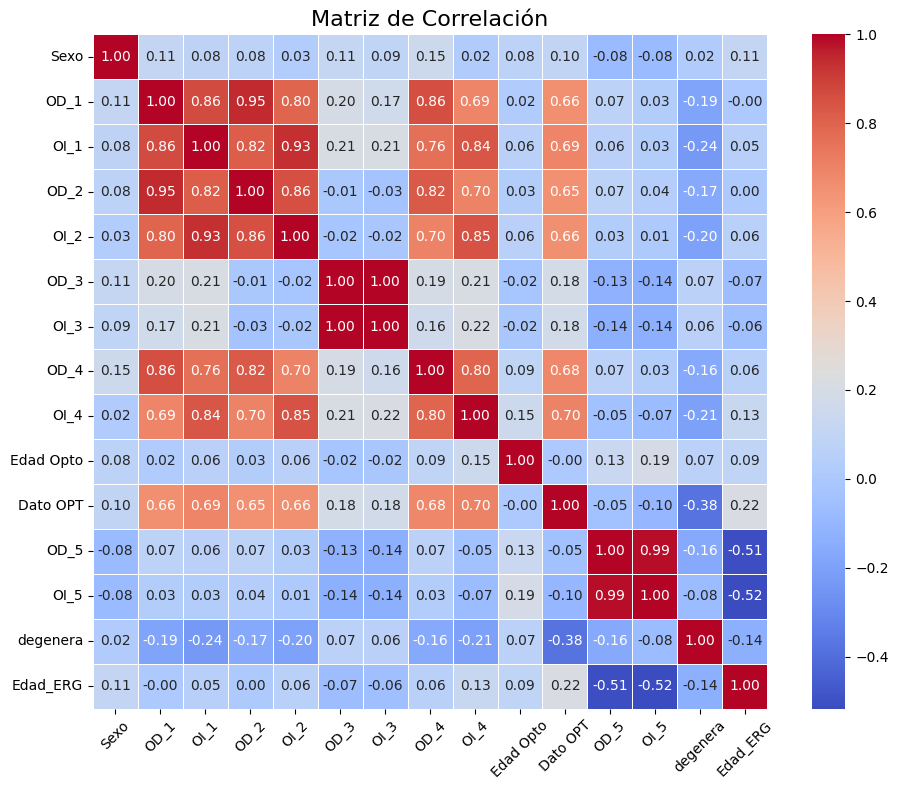

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular matriz de correlación
correlation_matrix = data.corr(numeric_only=True)

# Mostrar la matriz de correlación con un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Matriz de Correlación", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Definir características (X) y variable objetivo (y)
X = data.drop(columns=['degenera'])  # Eliminar la columna objetivo
y = data['degenera']  # Variable objetivo
# Dividir en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Escalar los datos (solo para modelos que lo necesitan)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print( X_train_scaled)
display (data)

[[-0.77990776 -1.1594742  -1.19428214 ...  0.97345399  0.8173628
  -0.9169251 ]
 [-0.77990776  0.43941929  0.64115237 ...  0.98278454  0.77538424
   0.42118098]
 [-2.48339049 -1.1594742  -1.19428214 ...  0.25030397  0.50791938
  -0.9169251 ]
 ...
 [ 0.92357497 -0.31143279  0.19240886 ...  0.06654985  0.34977229
   0.92297076]
 [ 0.92357497  1.04663759  0.9924229  ...  0.70575576  0.71193857
  -0.9169251 ]
 [ 0.92357497 -0.48000897 -0.15426389 ... -1.48373544 -1.51763681
   2.09381357]]


,Sexo,OD_1,OI_1,OD_2,OI_2,OD_3,OI_3,OD_4,OI_4,Edad Opto,Dato OPT,OD_5,OI_5,degenera,Edad_ERG
0,0.0,224.1,262.1,540.4,628.0,16.8,19.5,146.7,166.1,1.3,0.572,52.818,202.818,0.0,0.0
1,0.0,147.6,217.6,320.6,501.6,21.6,19.9,123.1,135.2,1.3,0.574,47.365,202.364,0.0,0.0
2,0.0,318.8,291.6,719.6,630.5,14.2,19.3,184.3,183.7,1.3,0.594,54.940,209.455,0.0,0.0
3,1.0,206.7,197.6,527.3,492.3,14.3,18.0,131.8,166.9,1.3,0.550,57.273,212.909,0.0,0.0
4,1.0,292.1,198.6,696.6,470.4,17.5,16.5,181.2,142.6,1.3,0.616,51.091,202.545,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,0.0,78.1,72.1,174.8,181.2,2.0,3.0,52.0,84.8,0.0,0.308,0.000,0.000,1.0,1.0
100,0.0,65.1,60.8,199.9,188.7,5.0,3.2,63.1,57.1,0.0,0.297,0.000,0.000,1.0,1.0
101,1.0,92.2,83.8,264.3,246.8,3.0,4.0,93.2,85.0,0.0,0.319,0.000,0.000,1.0,1.0
102,1.0,79.0,113.1,191.6,249.4,5.0,7.0,52.5,91.7,0.0,0.308,0.000,0.000,1.0,1.0


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Escalado de los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definir Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Random Forest (sin bootstrap)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# SVM (usa los datos escalados)
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)

# XGBoost
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)

# Modelo 1: Red Neuronal Densa (MLP)
model_mlp = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model_mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar MLP sin bootstrap
model_mlp.fit(X_train_scaled, y_train,
              epochs=50, batch_size=8,
              validation_data=(X_test_scaled, y_test),
              callbacks=[early_stopping])

# Modelo 2: Red Neuronal Profunda (DNN)
model_dnn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
model_dnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar DNN sin bootstrap
model_dnn.fit(X_train_scaled, y_train,
              epochs=100, batch_size=8,
              validation_data=(X_test_scaled, y_test),
              callbacks=[early_stopping])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.5302 - loss: 0.6810 - val_accuracy: 0.5714 - val_loss: 0.6805
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5983 - loss: 0.6688 - val_accuracy: 0.7143 - val_loss: 0.6704
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5415 - loss: 0.6805 - val_accuracy: 0.6667 - val_loss: 0.6638
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5614 - loss: 0.6618 - val_accuracy: 0.6667 - val_loss: 0.6458
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.7035 - loss: 0.6180 - val_accuracy: 0.7143 - val_loss: 0.6287
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.6783 - loss: 0.5706 - val_accuracy: 0.7143 - val_loss: 0.6228
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7169 - loss: 0.5934 - val_accuracy: 0.7143 - val_loss: 0.6222
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6552 - loss: 0.5790 - val_accuracy: 0.7143 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5017 - loss: 0.7202 - val_accuracy: 0.5238 - val_loss: 0.6969
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4941 - loss: 0.6939 - val_accuracy: 0.5714 - val_loss: 0.6861
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4991 - loss: 0.6608 - val_accuracy: 0.7143 - val_loss: 0.6693
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6368 - loss: 0.6504 - val_accuracy: 0.7619 - val_loss: 0.6558
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6949 - loss: 0.6132 - val_accuracy: 0.8095 - val_loss: 0.6484
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7319 - loss: 0.5754 - val_accuracy: 0.7619 - val_loss: 0.6485
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6741 - loss: 0.5870 - val_accuracy: 0.7619 - val_loss: 0.6325
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7472 - loss: 0.5848 - val_accuracy: 0.8095 - val_loss: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
🔹 Modelo: Red Neuronal 1 (DL)
✅ Accuracy: 0.4286
✅ F1-Score: 0.6000

🔹 Clasificación detallada:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        10
         1.0       0.47      0.82      0.60        11

    accuracy                           0.43        21
   macro avg       0.24      0.41      0.30        21
weighted avg       0.25      0.43      0.31        21



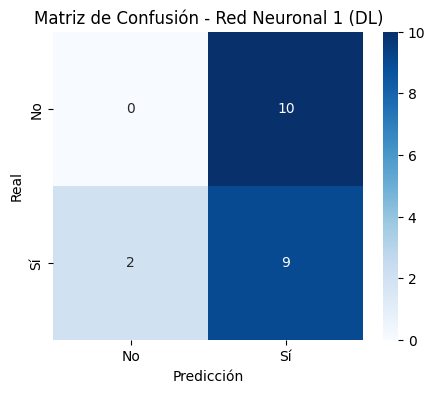

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
🔹 Modelo: Red Neuronal 2 (DL)
✅ Accuracy: 0.5238
✅ F1-Score: 0.6875

🔹 Clasificación detallada:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        10
         1.0       0.52      1.00      0.69        11

    accuracy                           0.52        21
   macro avg       0.26      0.50      0.34        21
weighted avg       0.27      0.52      0.36        21



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


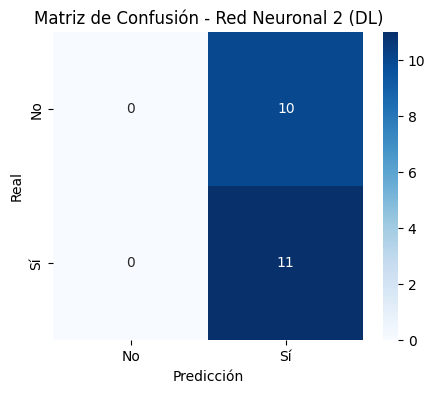

🔹 Modelo: Random Forest (ML)
✅ Accuracy: 1.0000
✅ F1-Score: 1.0000

🔹 Clasificación detallada:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        10
         1.0       1.00      1.00      1.00        11

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



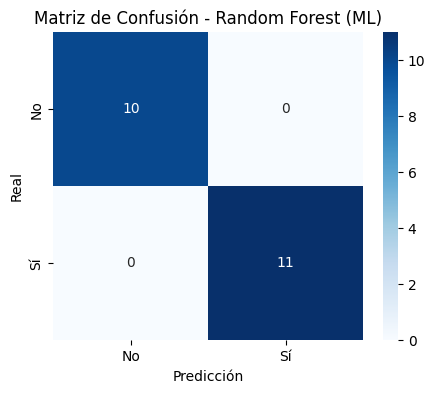

🔹 Modelo: SVM (ML)
✅ Accuracy: 0.5238
✅ F1-Score: 0.6875

🔹 Clasificación detallada:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        10
         1.0       0.52      1.00      0.69        11

    accuracy                           0.52        21
   macro avg       0.26      0.50      0.34        21
weighted avg       0.27      0.52      0.36        21



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_di

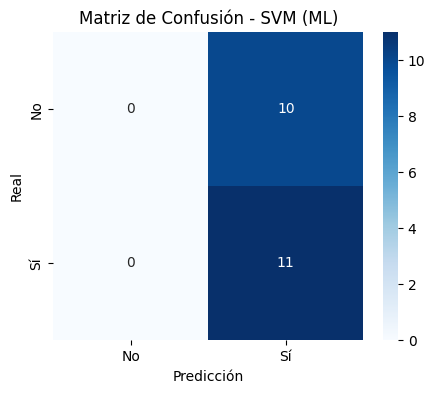

🔹 Modelo: XGBoost (Black Box)
✅ Accuracy: 0.9048
✅ F1-Score: 0.9167

🔹 Clasificación detallada:
               precision    recall  f1-score   support

         0.0       1.00      0.80      0.89        10
         1.0       0.85      1.00      0.92        11

    accuracy                           0.90        21
   macro avg       0.92      0.90      0.90        21
weighted avg       0.92      0.90      0.90        21



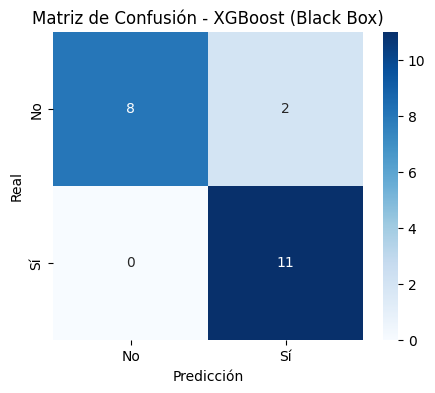

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
# Función para evaluar modelos
def evaluar_modelo(nombre, modelo, X_test, y_test):
    # Obtener las predicciones
    if hasattr(modelo, 'predict_proba'):  # Modelos que devuelven probabilidades (e.g. RandomForest, SVM, XGBoost)
        y_pred_prob = modelo.predict_proba(X_test)[:, 1]  # Extraemos las probabilidades de la clase positiva
        y_pred = (y_pred_prob > 0.5).astype(int)  # Convertimos las probabilidades a clases binarias
    else:  # Modelos que devuelven clases directamente (e.g. MLP, DNN)
        y_pred = modelo.predict(X_test)
        if y_pred.ndim > 1:  # Si el modelo devuelve un array 2D, extraemos la clase
            y_pred = (y_pred[:, 0] > 0.5).astype(int)

    # Calcular las métricas de evaluación
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    matriz_conf = confusion_matrix(y_test, y_pred)

    # Mostrar resultados
    print(f"🔹 Modelo: {nombre}")
    print(f"✅ Accuracy: {acc:.4f}")
    print(f"✅ F1-Score: {f1:.4f}")
    print("\n🔹 Clasificación detallada:\n", classification_report(y_test, y_pred))

    # Graficar la matriz de confusión
    plt.figure(figsize=(5, 4))
    sns.heatmap(matriz_conf, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Sí"], yticklabels=["No", "Sí"])
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.show()

# Evaluar todos los modelos
modelos = {
    "Red Neuronal 1 (DL)": model_mlp,
    "Red Neuronal 2 (DL)": model_dnn,
    "Random Forest (ML)": rf,
    "SVM (ML)": svm,
    "XGBoost (Black Box)": xgb
}

# Evaluar cada modelo
for nombre, modelo in modelos.items():
    evaluar_modelo(nombre, modelo, X_test, y_test)


In [1]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Función para evaluar modelos con selección automática de datos escalados o no
def evaluar_modelo(nombre, modelo, X_test, X_test_scaled, y_test):
    # Elegir qué datos usar según el tipo de modelo
    if nombre in ["SVM (ML)", "Red Neuronal 1 (DL)", "Red Neuronal 2 (DL)"]:
        X = X_test_scaled
    else:
        X = X_test

    # Obtener las predicciones
    if hasattr(modelo, 'predict_proba'):
        y_pred_prob = modelo.predict_proba(X)[:, 1]
        y_pred = (y_pred_prob > 0.5).astype(int)
    else:
        y_pred = modelo.predict(X)
        if y_pred.ndim > 1:
            y_pred = (y_pred[:, 0] > 0.5).astype(int)

    # Calcular métricas
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    matriz_conf = confusion_matrix(y_test, y_pred)

    # Mostrar resultados
    print(f"🔹 Modelo: {nombre}")
    print(f"✅ Accuracy: {acc:.4f}")
    print(f"✅ F1-Score: {f1:.4f}")
    print("\n🔹 Clasificación detallada:\n", classification_report(y_test, y_pred))

    # Graficar matriz de confusión
    plt.figure(figsize=(5, 4))
    sns.heatmap(matriz_conf, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Sí"], yticklabels=["No", "Sí"])
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.show()


In [ ]:
# Evaluar todos los modelos con decisión interna del tipo de datos
modelos = {
    "Red Neuronal 1 (DL)": model_mlp,
    "Red Neuronal 2 (DL)": model_dnn,
    "Random Forest (ML)": rf,
    "SVM (ML)": svm,
    "XGBoost (Black Box)": xgb
}

for nombre, modelo in modelos.items():
    evaluar_modelo(nombre, modelo, X_test, X_test_scaled, y_test)
